# Logistic Regression: Banking Marketing Campaign

## 1. Data Loading

In [9]:
# Handle imports upfront
import pandas as pd

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression

### 1.1. Load

In [28]:
import pandas as pd

# Set notebook wide random seed - this makes the random number generator determistic - we should get the same
# result every time we run things with randomness, e.g. test-train split
random_seed=315

# Read the data into a pandas dataframe from the URL
data_url='https://raw.githubusercontent.com/4GeeksAcademy/logistic-regression-project-tutorial/main/bank-marketing-campaign-data.csv'
data_df=pd.read_csv(data_url, sep=';')


### 1.2. Inspect

In [29]:
print(data_df.head)

<bound method NDFrame.head of        age          job  marital            education  default housing loan  \
0       56    housemaid  married             basic.4y       no      no   no   
1       57     services  married          high.school  unknown      no   no   
2       37     services  married          high.school       no     yes   no   
3       40       admin.  married             basic.6y       no      no   no   
4       56     services  married          high.school       no      no  yes   
...    ...          ...      ...                  ...      ...     ...  ...   
41183   73      retired  married  professional.course       no     yes   no   
41184   46  blue-collar  married  professional.course       no      no   no   
41185   56      retired  married    university.degree       no     yes   no   
41186   44   technician  married  professional.course       no      no   no   
41187   74      retired  married  professional.course       no     yes   no   

         contact mont


Missing values in each column:
Series([], dtype: int64)


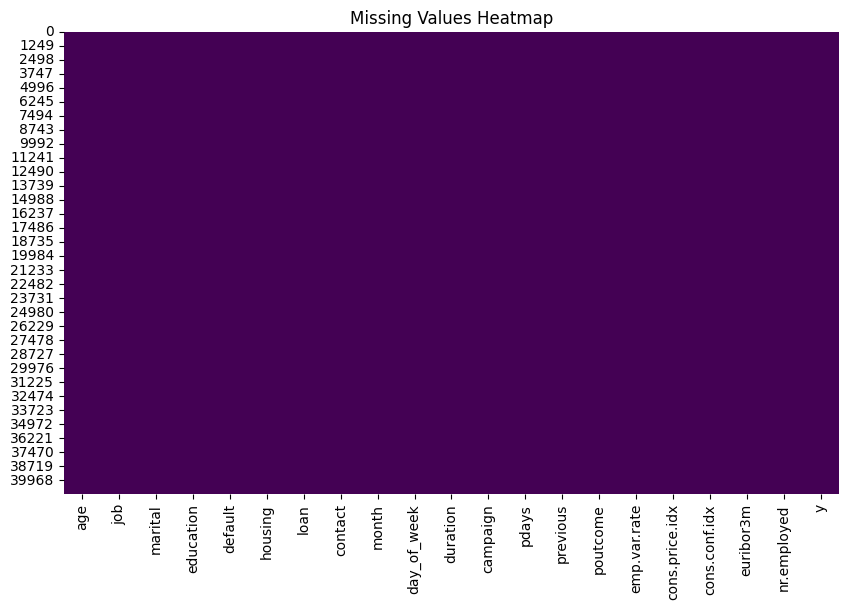

In [56]:
# Check for missing values
missing_values = data.isnull().sum()
print("\nMissing values in each column:")
print(missing_values[missing_values > 0])

# Visualize missing values
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

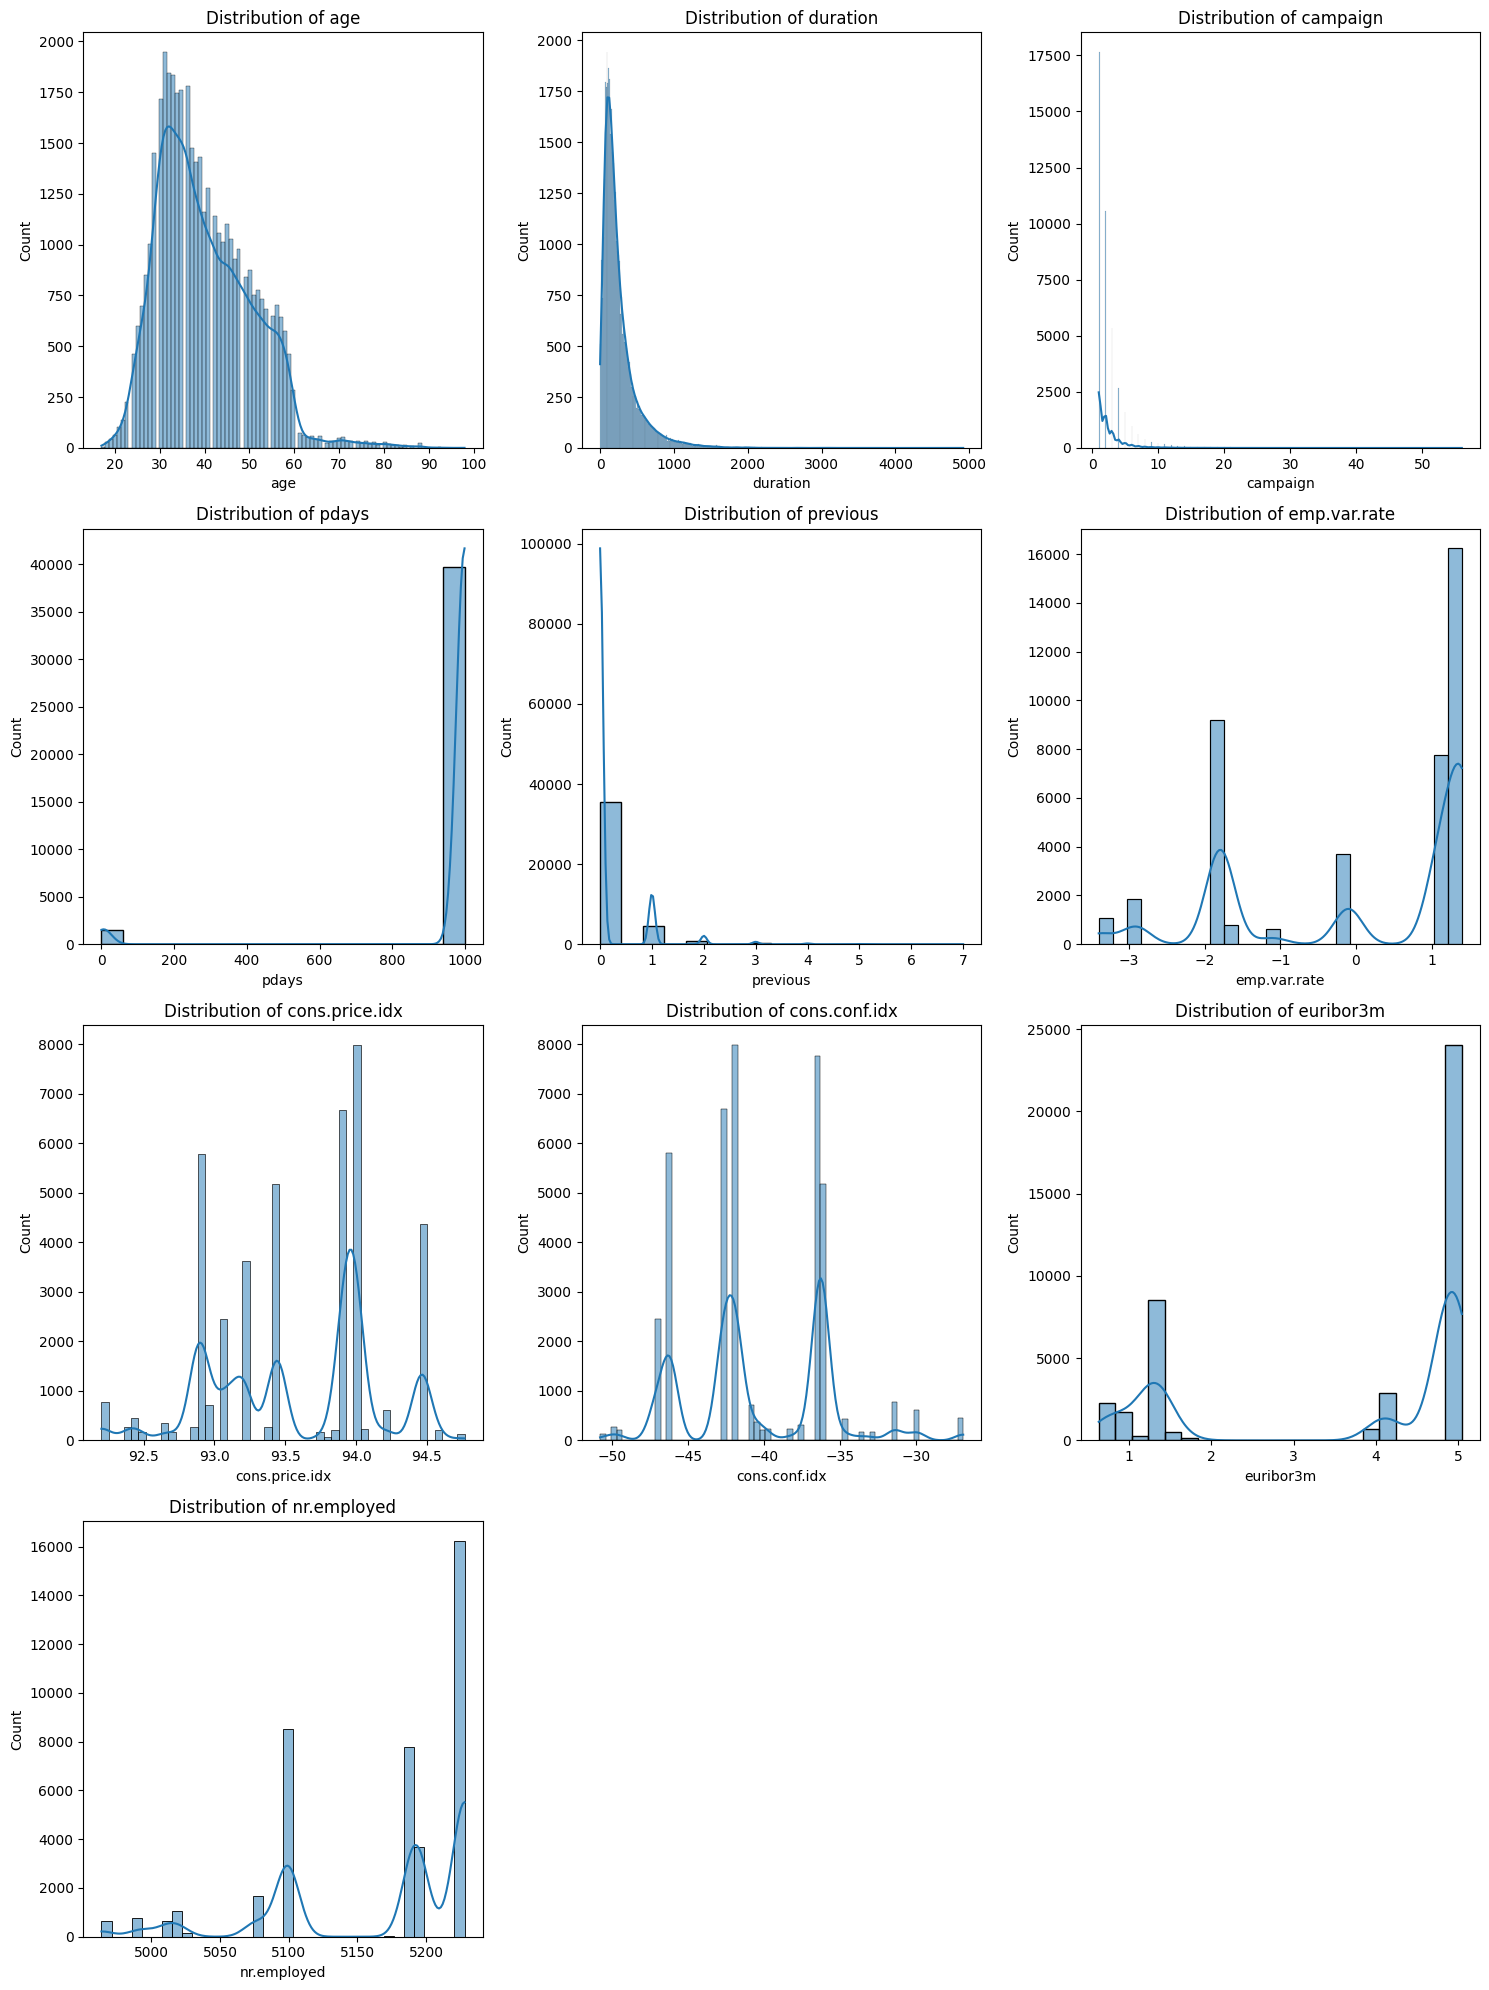

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get numerical columns
numerical_cols = data.select_dtypes(include=[np.number]).columns.tolist()

# Determine the number of rows and columns for subplots
num_cols = 3  # Number of columns in the subplot grid
num_rows = (len(numerical_cols) + num_cols - 1) // num_cols  # Calculate rows needed

# Distribution plots
plt.figure(figsize=(15, num_rows * 5))  # Adjust height based on number of rows
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.histplot(data[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

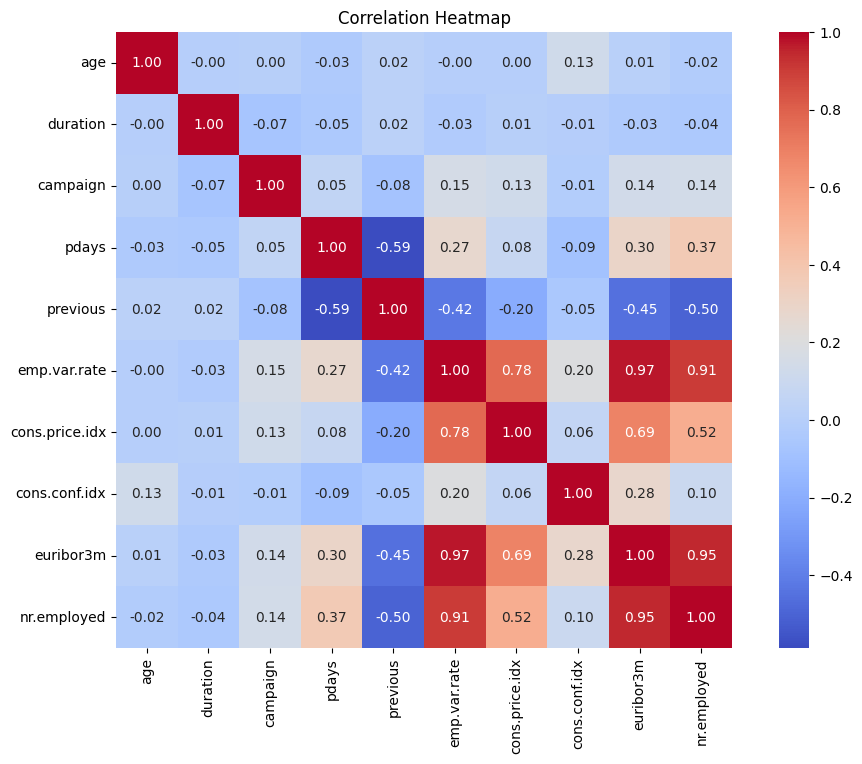

In [58]:
plt.figure(figsize=(12, 8))
correlation = data[numerical_cols].corr()
sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()

### 1.3. Train test Split

In [30]:
from sklearn.model_selection import train_test_split

# First separate the features from the labels
labels=data_df['y']
features=data_df.drop('y', axis=1)

# Do the test-train split
training_features, testing_features, training_labels, testing_labels=train_test_split(
    features,
    labels,
    test_size=0.33, 
    random_state=random_seed
)

In [31]:
# Inspect the first few rows, transposing so columns don't get cut off
training_features.head().transpose()

,22762,5889,20999,24505,9191
age,45,52,56,46,35
job,technician,blue-collar,blue-collar,admin.,unemployed
marital,divorced,married,married,married,married
education,professional.course,basic.4y,basic.4y,high.school,university.degree
default,no,no,no,unknown,no
housing,yes,yes,yes,no,no
loan,no,no,no,no,no
contact,cellular,telephone,cellular,cellular,telephone
month,aug,may,aug,nov,jun
day_of_week,mon,mon,thu,mon,fri


In [32]:
training_features.nunique()

age                 76
job                 12
marital              4
education            8
default              3
housing              3
loan                 3
contact              2
month               10
day_of_week          5
duration          1412
campaign            41
pdays               25
previous             8
poutcome             3
emp.var.rate        10
cons.price.idx      26
cons.conf.idx       26
euribor3m          310
nr.employed         11
dtype: int64

In [33]:
# Define a reusable helper function here, since we will be looking at feature composition a lot
def feature_composition(df: pd.DataFrame, features: list) -> None:
    '''Takes a dataframe and a list of features. Prints out
    the unique levels of that feature with their count and 
    percent.'''

    for i, column_name in enumerate(features):
        value_counts=df[column_name].value_counts().T.to_dict()

        print(f'\nFeature: {column_name}')

        for key, value in value_counts.items():
            percent_value=(value/len(data_df)) * 100
            print(f' {key}: {value} ({percent_value:.1f}%)')

In [34]:

feature_composition(training_features, ['default','housing','loan','poutcome'])


Feature: default
 no: 21808 (52.9%)
 unknown: 5785 (14.0%)
 yes: 2 (0.0%)

Feature: housing
 yes: 14415 (35.0%)
 no: 12505 (30.4%)
 unknown: 675 (1.6%)

Feature: loan
 no: 22736 (55.2%)
 yes: 4184 (10.2%)
 unknown: 675 (1.6%)

Feature: poutcome
 nonexistent: 23810 (57.8%)
 failure: 2853 (6.9%)
 success: 932 (2.3%)


In [35]:
feature_composition(training_features, ['pdays'])


Feature: pdays
 999: 26567 (64.5%)
 3: 291 (0.7%)
 6: 280 (0.7%)
 4: 83 (0.2%)
 9: 46 (0.1%)
 7: 41 (0.1%)
 2: 40 (0.1%)
 12: 39 (0.1%)
 10: 35 (0.1%)
 5: 33 (0.1%)
 13: 21 (0.1%)
 1: 18 (0.0%)
 11: 18 (0.0%)
 14: 17 (0.0%)
 8: 13 (0.0%)
 15: 12 (0.0%)
 0: 11 (0.0%)
 16: 9 (0.0%)
 17: 8 (0.0%)
 18: 6 (0.0%)
 22: 2 (0.0%)
 19: 2 (0.0%)
 27: 1 (0.0%)
 25: 1 (0.0%)
 26: 1 (0.0%)


## Feature Engineering

In [36]:
# Names of columns to drop
column_drops=['poutcome', 'pdays', 'previous']

# Do the drops
training_features.drop(column_drops, axis=1, inplace=True)

# Do the same thing to the testing data
testing_features.drop(column_drops, axis=1, inplace=True)

# Take a look
training_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27595 entries, 22762 to 29283
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             27595 non-null  int64  
 1   job             27595 non-null  object 
 2   marital         27595 non-null  object 
 3   education       27595 non-null  object 
 4   default         27595 non-null  object 
 5   housing         27595 non-null  object 
 6   loan            27595 non-null  object 
 7   contact         27595 non-null  object 
 8   month           27595 non-null  object 
 9   day_of_week     27595 non-null  object 
 10  duration        27595 non-null  int64  
 11  campaign        27595 non-null  int64  
 12  emp.var.rate    27595 non-null  float64
 13  cons.price.idx  27595 non-null  float64
 14  cons.conf.idx   27595 non-null  float64
 15  euribor3m       27595 non-null  float64
 16  nr.employed     27595 non-null  float64
dtypes: float64(5), int64(3), object(

In [37]:
feature_composition(training_features, ['day_of_week'])


Feature: day_of_week
 thu: 5790 (14.1%)
 mon: 5690 (13.8%)
 wed: 5423 (13.2%)
 tue: 5402 (13.1%)
 fri: 5290 (12.8%)


In [38]:
feature_composition(training_features, ['month'])


Feature: month
 may: 9143 (22.2%)
 jul: 4780 (11.6%)
 aug: 4161 (10.1%)
 jun: 3618 (8.8%)
 nov: 2772 (6.7%)
 apr: 1765 (4.3%)
 oct: 474 (1.2%)
 sep: 398 (1.0%)
 mar: 358 (0.9%)
 dec: 126 (0.3%)


In [39]:
import numpy as np

# Don't worry about downcasting FutureWarning
pd.set_option('future.no_silent_downcasting', True)

# Define a helper function here so we can encode the time
# features the same way on the training and testing data
# without copy-pasting the same code
def encode_time_features(data_df: pd.DataFrame) -> pd.DataFrame:
    '''Takes a Pandas dataframe and uses cyclical sin/cos to encode
    month and day features. Returns updated dataframe.'''

    # First convert the features to numeric
    dict={'mon' : 1, 'tue' : 2, 'wed': 3, 'thu' : 4, 'fri': 5}
    data_df=data_df.replace(dict)

    dict={'jan' : 1, 'feb' : 2, 'mar': 3, 'apr' : 4, 'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}
    data_df=data_df.replace(dict)

    # And fix the dtypes
    data_df['day_of_week']=data_df['day_of_week'].astype(int)
    data_df['month']=data_df['month'].astype(int)

    # Now encode the day and month with sin/cos components
    data_df['day_sin'] = np.sin(2 * np.pi * data_df['day_of_week']/7.0)
    data_df['day_cos'] = np.cos(2 * np.pi * data_df['day_of_week']/7.0)

    data_df['month_sin'] = np.sin(2 * np.pi * data_df['month']/12.0)
    data_df['month_cos'] = np.cos(2 * np.pi * data_df['month']/12.0)

    # Drop the original string features
    data_df.drop(['month', 'day_of_week'], axis=1, inplace=True)

    return data_df

In [40]:
# Encode the training and testing features the same way
training_features=encode_time_features(training_features)
testing_features=encode_time_features(testing_features)

In [41]:
feature_composition(training_features, ['education'])


Feature: education
 university.degree: 8097 (19.7%)
 high.school: 6426 (15.6%)
 basic.9y: 4038 (9.8%)
 professional.course: 3465 (8.4%)
 basic.4y: 2834 (6.9%)
 basic.6y: 1568 (3.8%)
 unknown: 1154 (2.8%)
 illiterate: 13 (0.0%)


In [42]:
# Dictionary to translate employment string to numerical value
dict={'unknown': 0, 'illiterate': 1, 'basic.4y': 2, 'basic.6y': 3, 'basic.9y': 4, 'high.school': 5, 'professional.course': 6, 'university.degree': 7}

# Encode the training and testing data
training_features=training_features.replace(dict)
testing_features=testing_features.replace(dict)

# Fix the dtypes
training_features['education']=training_features['education'].astype(int)
testing_features['education']=testing_features['education'].astype(int)

In [43]:
feature_composition(training_features, ['job'])


Feature: job
 admin.: 7002 (17.0%)
 blue-collar: 6225 (15.1%)
 technician: 4463 (10.8%)
 services: 2643 (6.4%)
 management: 1950 (4.7%)
 retired: 1177 (2.9%)
 entrepreneur: 995 (2.4%)
 self-employed: 932 (2.3%)
 housemaid: 708 (1.7%)
 unemployed: 686 (1.7%)
 student: 586 (1.4%)
 0: 228 (0.6%)


In [44]:
# Names of columns we want to encode
encoded_columns=['job','marital','default','housing','loan','contact']

# Do the encoding
training_features=pd.get_dummies(training_features, columns=encoded_columns, dtype=int, drop_first=True)
testing_features=pd.get_dummies(testing_features, columns=encoded_columns, dtype=int, drop_first=True)

training_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27595 entries, 22762 to 29283
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                27595 non-null  int64  
 1   education          27595 non-null  int64  
 2   duration           27595 non-null  int64  
 3   campaign           27595 non-null  int64  
 4   emp.var.rate       27595 non-null  float64
 5   cons.price.idx     27595 non-null  float64
 6   cons.conf.idx      27595 non-null  float64
 7   euribor3m          27595 non-null  float64
 8   nr.employed        27595 non-null  float64
 9   day_sin            27595 non-null  float64
 10  day_cos            27595 non-null  float64
 11  month_sin          27595 non-null  float64
 12  month_cos          27595 non-null  float64
 13  job_admin.         27595 non-null  int64  
 14  job_blue-collar    27595 non-null  int64  
 15  job_entrepreneur   27595 non-null  int64  
 16  job_housemaid      2759

In [45]:
training_features.head()

,age,education,duration,campaign,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,day_sin,...,marital_divorced,marital_married,marital_single,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,contact_telephone
22762,45,6,112,2,1.4,93.444,-36.1,4.965,5228.1,0.781831,...,1,0,0,1,0,0,1,1,0,0
5889,52,2,253,2,1.1,93.994,-36.4,4.857,5191.0,0.781831,...,0,1,0,1,0,0,1,1,0,1
20999,56,2,366,1,1.4,93.444,-36.1,4.964,5228.1,-0.433884,...,0,1,0,1,0,0,1,1,0,0
24505,46,5,76,3,-0.1,93.200,-42.0,4.191,5195.8,0.781831,...,0,1,0,0,0,1,0,1,0,0
9191,35,7,360,2,1.4,94.465,-41.8,4.967,5228.1,-0.974928,...,0,1,0,1,0,1,0,1,0,1


In [46]:
from sklearn.preprocessing import StandardScaler

# Scale the features
standard_scaler=StandardScaler().fit(training_features)
training_features=standard_scaler.transform(training_features)
testing_features=standard_scaler.transform(testing_features)

print(f'Training features are: {type(training_features)}')
print(f'Training features shape: {training_features.shape}')

Training features are: <class 'numpy.ndarray'>
Training features shape: (27595, 34)


In [47]:
from sklearn.preprocessing import LabelEncoder

# Last, encode the labels
label_encoder=LabelEncoder().fit(training_labels)
training_labels=label_encoder.transform(training_labels)
testing_labels=label_encoder.transform(testing_labels)

print(f'Training labels: {training_labels}')

Training labels: [0 0 0 ... 0 0 0]


## 3. Classifier Optimization

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Train the model on the training data
base_model=LogisticRegression(random_state=random_seed)
base_model.fit(training_features, training_labels)

# Make predictions
base_training_predictions=base_model.predict(training_features)

# Score for accuracy
percent_accuracy=accuracy_score(training_labels, base_training_predictions) * 100
print(f'Model is {percent_accuracy:.1f}% accurate on the training data.')

Model is 90.8% accurate on the training data.


In [49]:
print(f'Data is {float(1 - (sum(training_labels) / len(training_labels))) * 100:.1f}% "no"')

Data is 88.9% "no"


In [50]:
# Train the model
weighted_model=LogisticRegression(random_state=random_seed, class_weight='balanced')
weighted_model.fit(training_features, training_labels)

# Make predictions
weighted_training_predictions=weighted_model.predict(training_features)

# Score for accuracy
percent_accuracy=accuracy_score(training_labels, weighted_training_predictions) * 100
print(f'Model is {percent_accuracy:.1f}% accurate on the training data.')

Model is 85.1% accurate on the training data.


## 4. Performance

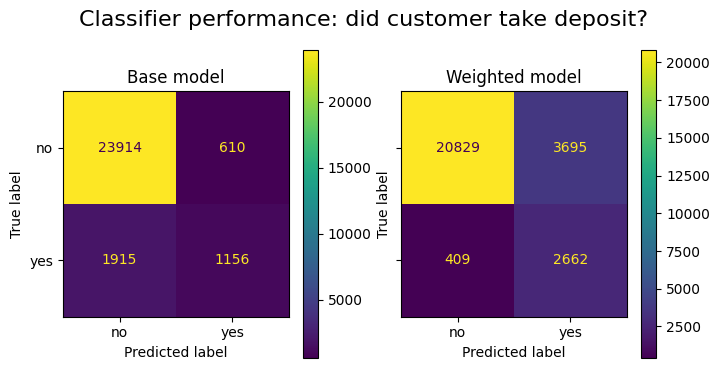

Model base model is 90.8% accurate on the training data.
Model weighted model is 85.1% accurate on the weighted data.


In [52]:
from sklearn.metrics import ConfusionMatrixDisplay

# Set-up two subplots for the training and testing confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

# Set the figure and individual plot titles
fig.suptitle('Classifier performance: did customer take deposit?', fontsize=16)
axes[0].set_title('Base model')
axes[1].set_title('Weighted model')

# Plot the training data performance
_=ConfusionMatrixDisplay.from_estimator(
    estimator=base_model,
    X=training_features,
    y=training_labels,
    display_labels=label_encoder.classes_,
    #normalize='all',
    ax=axes[0]
)

# Plot the testing data performance
_=ConfusionMatrixDisplay.from_estimator(
    estimator=weighted_model,
    X=training_features,
    y=training_labels,
    display_labels=label_encoder.classes_,
    #normalize='all',
    ax=axes[1]
)

plt.show()

base_training_predictions=base_model.predict(training_features)
percent_accuracy=accuracy_score(training_labels, base_training_predictions) * 100
print(f'Model base model is {percent_accuracy:.1f}% accurate on the training data.')

weighted_training_predictions=weighted_model.predict(training_features)
percent_accuracy=accuracy_score(training_labels, weighted_training_predictions) * 100
print(f'Model weighted model is {percent_accuracy:.1f}% accurate on the weighted data.')

## 5. Classification loss: binary cross-entropy

In [53]:
from sklearn.metrics import matthews_corrcoef

base_mcc=matthews_corrcoef(training_labels, base_training_predictions)
weighted_mcc=matthews_corrcoef(training_labels, weighted_training_predictions)

print(f'Base model Mathews correlation: {base_mcc:.3f}')
print(f'Weighted Mathews correlation: {weighted_mcc:.3f}')

Base model Mathews correlation: 0.452
Weighted Mathews correlation: 0.535
